In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #for GPU usage
#import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import callbacks, optimizers
from keras.utils import multi_gpu_model
import tensorflow as tf

import DataPreprocessing as DP
from matplotlib import pyplot as plt
from astropy.io import fits
#from skimage import exposure
#------------------------------------------------------------------------#
import time
Tstart = time.time() #Timer start

In [3]:
# 使用第一张与第三张GPU卡
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpus = tf.config.experimental.list_physical_devices(device_type='XLA_GPU')
#cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus)
tf.config.experimental.set_visible_devices(devices=gpus, device_type='XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]


In [4]:
#norm spectrum
kinds = ['boss_cv','boss_da+ms','boss_db','boss_db+ms','boss_dq','boss_dz','fgkm','hotstars','wd','wdsb2','yso','hotstars_m']
flux_cv, spectrum_cv = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[0]+'/'+'*.fit')
flux_dams, spectrum_dams = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[1]+'/'+'*.fit')
flux_db, spectrum_db = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[2]+'/'+'*.fit')

In [5]:
#delate bad data
n = 0
for i in range(len(spectrum_db)):
    if len(spectrum_db[i][0]) < 4096:
        n = i
flux_db.pop(n)
spectrum_db.pop(n)

[array([5282.0195, 5283.235 , 5284.453 , 5285.669 , 5286.8877, 5288.104 ,
        5289.323 , 5290.54  , 5291.7573, 5292.9775, 5294.1953, 5295.416 ,
        5296.6343, 5297.8555, 5299.074 , 5300.2935, 5301.5156, 5302.7354,
        5303.958 , 5305.178 , 5306.4014, 5307.622 , 5308.8433, 5310.0674,
        5311.289 , 5312.5137, 5313.736 , 5314.9614, 5316.184 , 5317.407 ,
        5318.6333, 5319.857 , 5321.0835, 5322.3076, 5323.5347, 5324.76  ,
        5325.9844, 5327.213 , 5328.438 , 5329.667 , 5330.893 , 5332.122 ,
        5333.349 , 5334.5757, 5335.806 , 5337.0337, 5338.264 , 5339.492 ,
        5340.7236, 5341.952 , 5343.181 , 5344.413 , 5345.6426, 5346.8755,
        5348.1055, 5349.339 , 5350.5693, 5351.8003, 5353.034 , 5354.2656,
        5355.5005, 5356.7324, 5357.968 , 5359.2   , 5360.433 , 5361.6694,
        5362.903 , 5364.139 , 5365.3735, 5366.611 , 5367.845 , 5369.08  ,
        5370.3184, 5371.5537, 5372.7925, 5374.0283, 5375.2676, 5376.504 ,
        5377.744 , 5378.981 , 5380.218

In [6]:
#input spectrum
l_list =  flux_cv+flux_dams+flux_db
sl = []
for i in range(len(l_list)):
    sl.append(len(l_list[i]))
#sl_min = np.min(sl)
X_train = []
for i in range(len(l_list)):
    X_train.append(l_list[i][0:4096])
size = 4096
#X_train = l_list
X_train = np.stack(X_train)
#X_train = X_train.reshape(len(X_train),size,1) #change the shape to NHWC for CAE input
X_train = X_train.reshape(len(X_train),size)
print(X_train.shape) #print information of training samples

(1214, 4096)


In [7]:
input_spe = Input(shape=(4096,1))

In [8]:
# x = Conv1D(256, 9, activation='relu', padding='same')(input_spe)#(4096,256)
# x = MaxPooling1D(2, padding='same')(x)#(2048,256)
# x = Conv1D(128, 8, activation='relu', padding='same')(x)#(2048,128)
# x = MaxPooling1D(2, padding='same')(x)#(1024,128)
# x = Conv1D(64, 7, activation='relu', padding='same')(x)#(1024,64)
# x = MaxPooling1D(2, padding='same')(x)#(512,64)
# x = Conv1D(32, 3, activation='relu', padding='same')(x)#(512,32)
# x = MaxPooling1D(2, padding='same')(x)#(256,32)
# x = Conv1D(32, 3, activation='relu', padding='same')(input_spe)#(4096,16)
# x = MaxPooling1D(8, padding='same')(x)#(512,16)
x = Conv1D(32, 8, activation='relu', padding='same')(input_spe)#(4096,8)
x = MaxPooling1D(16, padding='same')(x)#(256,8)

x = Flatten()(x)
# x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
encoded = Dense(units=2, activation='relu', name='embedding')(x)
x = Dense(units=512, activation='relu')(encoded)
# x = Dense(units=1024, activation='relu')(x)
x = Dense(units=2048, activation='relu')(x)
x = Reshape((256,8))(x)
x.shape

#encoded = Conv1D(8,3, activation='relu', name='embedding')(x)

x = Conv1D(32, 8, activation='relu', padding='same')(x)#(64,8)
x = UpSampling1D(16)(x)#(512,8)
# x = Conv1D(16, 3, activation='relu', padding='same')(x)#(512,16)
# x = UpSampling1D(8)(x)#(4096,16)
# # x = Conv1D(32, 3, activation='relu', padding='same')(x)#
# # x = UpSampling1D(2)(x)#(512,32)
# # x = Conv1D(64, 7, activation='relu', padding='same')(x)#(512,64)
# # x = UpSampling1D(2)(x)#(1024,64)
# # x = Conv1D(128, 8, activation='relu', padding='same')(x)#(1024,128)
# # x = UpSampling1D(2)(x)#(2048,128)
# # x = Conv1D(256, 9, activation='relu', padding='same')(x)#(2048,256)
# # x = UpSampling1D(2)(x)#(4096,256)
decoded = Dense(1,activation='softmax')(x)

autoencoder = Model(input_spe, decoded)
#autoencoder = multi_gpu_model(input_spe, decoded)
optimizer_adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])####loss function
#autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4096, 32)          288       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 256, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
embedding (Dense)            (None, 2)                 1026      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536  

In [9]:
Nepochs = 100 #number of epochs for CAE training
tosavemodel = True #if save the trained CAE model
plot_reconstruction = True #if plot the reconstruction comparison
savename = 'AE_reconstruction' #setup if "tosavemodel=True" or "plot_reconstuction=True"

In [10]:
Tprocess0 = time.time()
print('\n', '## DATE PREPARATION RUNTIME:', Tprocess0-Tstart) #Timer

## MAIN ##
#training
H = autoencoder.fit(X_train, X_train,
                epochs=Nepochs,
                shuffle=True)

Tprocess1 = time.time()
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0) #Timer


 ## DATE PREPARATION RUNTIME: 53.8665406703949
Epoch 1/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0273 - accuracy: 2.0110e-07
Epoch 2/100
38/38 [==============================] - 1s 24ms/step - loss: 34064.0273 - accuracy: 2.0110e-07
Epoch 3/100
38/38 [==============================] - 1s 22ms/step - loss: 34064.0352 - accuracy: 2.0110e-07
Epoch 4/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 5/100
38/38 [==============================] - 1s 24ms/step - loss: 34064.0352 - accuracy: 2.0110e-07
Epoch 6/100
38/38 [==============================] - 1s 24ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 7/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 8/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0352 - accuracy: 2.0110e-07
Epoch 9/100
38/38 [==============================] - 1s 24ms/step - loss: 34064.0352 - a

38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 76/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 77/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 78/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0352 - accuracy: 2.0110e-07
Epoch 79/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 80/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 81/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0352 - accuracy: 2.0110e-07
Epoch 82/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0312 - accuracy: 2.0110e-07
Epoch 83/100
38/38 [==============================] - 1s 23ms/step - loss: 34064.0352 - accuracy: 2.0110e-07
Epoch 84/100
38/38 [============

In [14]:
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0)


 ## AE TRAINING RUNTIME: 96.09190320968628


/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


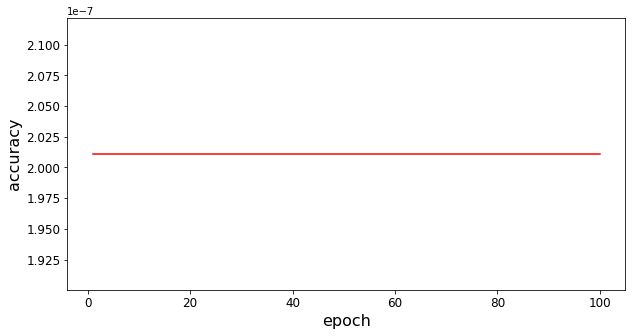

In [15]:
#plot loss function and accuracy function
acc = H.history['accuracy']
loss = H.history['loss']
plt.figure(figsize=[10,5])
font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size' : 16,
    }

epochs = range(1,Nepochs+1)
 
#plt.title('Accuracy')
plt.plot(epochs, acc,'red')
plt.xlabel('epoch',font2)
plt.ylabel('accuracy',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()

/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


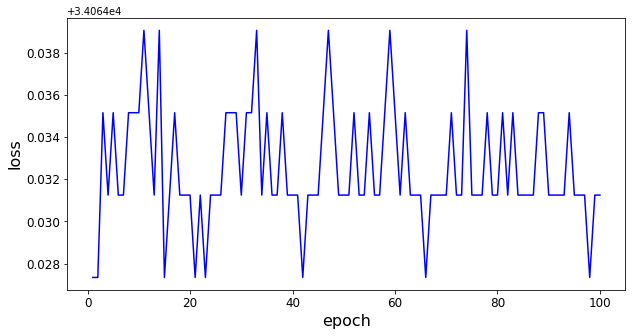

In [16]:
#plot loss function and accuracy function
 
#plt.title('Loss')
plt.figure(figsize=[10,5])
plt.plot(epochs, loss, 'blue')
plt.xlabel('epoch',font2)
plt.ylabel('loss',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()